# NeuralProphet

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error

from neuralprophet import NeuralProphet, set_random_seed, set_log_level
set_log_level("ERROR")

import warnings
warnings.filterwarnings('ignore')

import argparse
# import wandb
# wandb.init(project="DACON_235942", name="neuralprophet")

parser = argparse.ArgumentParser(description="neuralprophet")
parser.add_argument('--yearly_seasonality', default=50, type=int)
parser.add_argument('--seasonality_mode', default="multiplicative", type=str) # additive or multiplicative
parser.add_argument('--seed', default=1011, type=int)
args = parser.parse_args('')

# wandb.config.update(args)

yearly_seasonality = args.yearly_seasonality
seasonality_mode = args.seasonality_mode
seed = args.seed

def set_seeds(seed=seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    set_random_seed(seed)

set_seeds()

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

train.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68


## Preprocessing

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            6255 non-null   int64  
 1   Store         6255 non-null   int64  
 2   Date          6255 non-null   object 
 3   Temperature   6255 non-null   float64
 4   Fuel_Price    6255 non-null   float64
 5   Promotion1    2102 non-null   float64
 6   Promotion2    1592 non-null   float64
 7   Promotion3    1885 non-null   float64
 8   Promotion4    1819 non-null   float64
 9   Promotion5    2115 non-null   float64
 10  Unemployment  6255 non-null   float64
 11  IsHoliday     6255 non-null   bool   
 12  Weekly_Sales  6255 non-null   float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 592.6+ KB


In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            180 non-null    int64  
 1   Store         180 non-null    int64  
 2   Date          180 non-null    object 
 3   Temperature   180 non-null    float64
 4   Fuel_Price    180 non-null    float64
 5   Promotion1    178 non-null    float64
 6   Promotion2    45 non-null     float64
 7   Promotion3    161 non-null    float64
 8   Promotion4    146 non-null    float64
 9   Promotion5    180 non-null    float64
 10  Unemployment  180 non-null    float64
 11  IsHoliday     180 non-null    bool   
dtypes: bool(1), float64(8), int64(2), object(1)
memory usage: 15.8+ KB


### Weekly_Sales

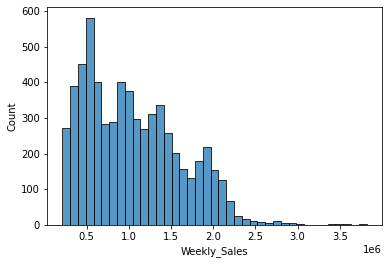

In [4]:
sns.histplot(train["Weekly_Sales"])
plt.show()

In [5]:
# for i in train["Store"].unique():
#     temp = train[train["Store"]==i]
#     plt.figure(figsize=(15,8))
#     sns.lineplot(x="Date", y="Weekly_Sales", data=temp)
#     plt.title(f"Store : {i}")
#     plt.xticks('off')
#     plt.show()

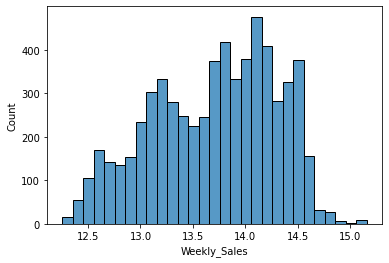

In [6]:
train["Weekly_Sales"] = np.log(train["Weekly_Sales"])
sns.histplot(train["Weekly_Sales"])
plt.show()

In [7]:
# for i in train["Store"].unique():
#     temp = train[train["Store"]==i]
#     plt.figure(figsize=(15,8))
#     sns.lineplot(x="Date", y="Weekly_Sales", data=temp)
#     plt.title(f"Store : {i}")
#     plt.xticks('off')
#     plt.show()

### Store

In [8]:
train["Store"] = train["Store"].astype("object")
test["Store"] = test["Store"].astype("object")

train["Store"].nunique(), test["Store"].nunique()

(45, 45)

### Date

In [9]:
train["Date"] = pd.to_datetime(train["Date"])
test["Date"] = pd.to_datetime(test["Date"])

train.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,14.312455
1,2,1,2010-12-02,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,14.311400
2,3,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,14.292966
3,4,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,14.158907
4,5,1,2010-05-03,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,14.256862


In [10]:
def seperate_datetime(df):
    year = []
    month = []
    day = []
    for date in df:
        year_point, month_point, day_point = date.split('-')
        year.append(int(year_point))
        month.append(int(month_point))
        day.append(int(day_point))
    return year, month, day

train_year, train_month, train_day = seperate_datetime(train["Date"].astype("str"))
test_year, test_month, test_day = seperate_datetime(test["Date"].astype("str"))
    
train['year'] = train_year
train['month'] = train_month
train['day'] = train_day

test['year'] = test_year
test['month'] = test_month
test['day'] = test_day

train["week"] = train["Date"].dt.week
test["week"] = test["Date"].dt.week

def seasonal(x):
    if (x >= 3) & (x <= 5):
        x = 1
    elif (x >= 6) & (x <= 8):
        x = 2
    elif (x >= 9) & (x <= 11):
        x = 3
    elif (x >= 12) | (x <= 2):
        x = 4
    return x

train["season"] = train["month"].apply(lambda x : seasonal(x))
test["season"] = test["month"].apply(lambda x : seasonal(x))

train.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,year,month,day,week,season
0,1,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,14.312455,2010,5,2,17,1
1,2,1,2010-12-02,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,14.311400,2010,12,2,48,4
2,3,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,14.292966,2010,2,19,7,4
3,4,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,14.158907,2010,2,26,8,4
4,5,1,2010-05-03,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,14.256862,2010,5,3,18,1


### IsHoliday

In [11]:
train["event"] = train["IsHoliday"].apply(lambda x : "holyday" if x==True else 0)
test["event"] = test["IsHoliday"].apply(lambda x : "holyday" if x==True else 0)

train.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,year,month,day,week,season,event
0,1,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,14.312455,2010,5,2,17,1,0
1,2,1,2010-12-02,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,14.311400,2010,12,2,48,4,holyday
2,3,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,14.292966,2010,2,19,7,4,0
3,4,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,14.158907,2010,2,26,8,4,0
4,5,1,2010-05-03,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,14.256862,2010,5,3,18,1,0


## Training

In [12]:
total = pd.concat([train, test], axis=0).reset_index(drop=True).sort_values("Date")
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6435 entries, 4343 to 6380
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            6435 non-null   int64         
 1   Store         6435 non-null   object        
 2   Date          6435 non-null   datetime64[ns]
 3   Temperature   6435 non-null   float64       
 4   Fuel_Price    6435 non-null   float64       
 5   Promotion1    2280 non-null   float64       
 6   Promotion2    1637 non-null   float64       
 7   Promotion3    2046 non-null   float64       
 8   Promotion4    1965 non-null   float64       
 9   Promotion5    2295 non-null   float64       
 10  Unemployment  6435 non-null   float64       
 11  IsHoliday     6435 non-null   bool          
 12  Weekly_Sales  6255 non-null   float64       
 13  year          6435 non-null   int64         
 14  month         6435 non-null   int64         
 15  day           6435 non-null   int64

In [13]:
total["year"].value_counts() / total["Store"].nunique()

2011    52.0
2010    48.0
2012    43.0
Name: year, dtype: float64

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

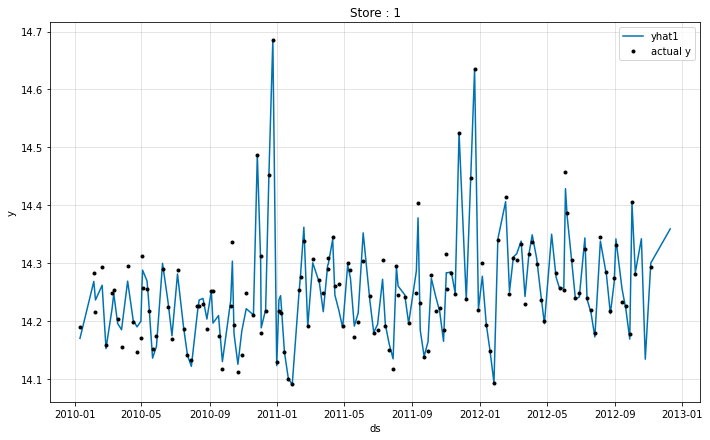

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

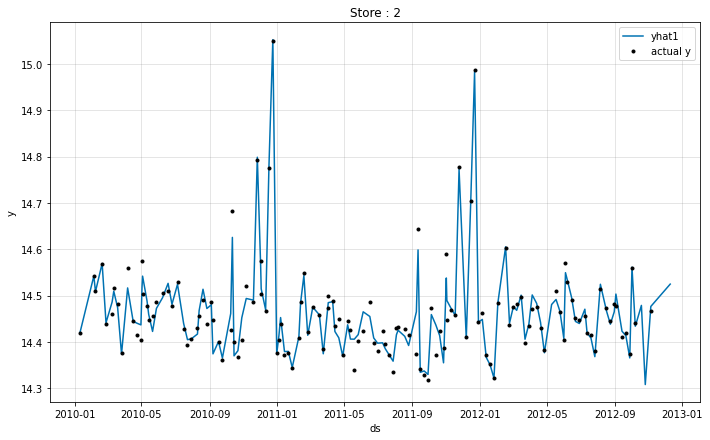

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

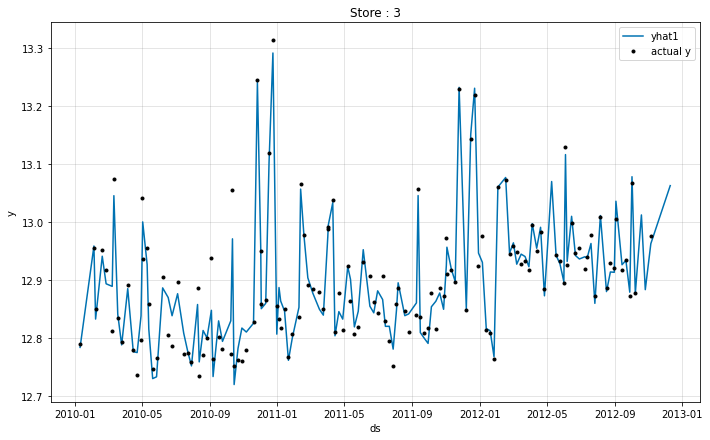

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

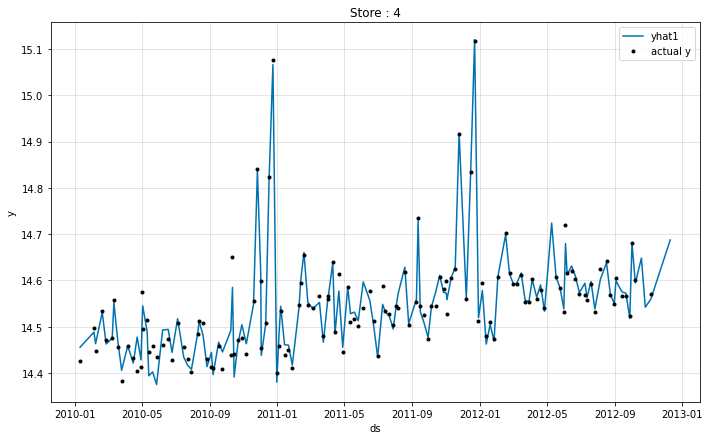

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

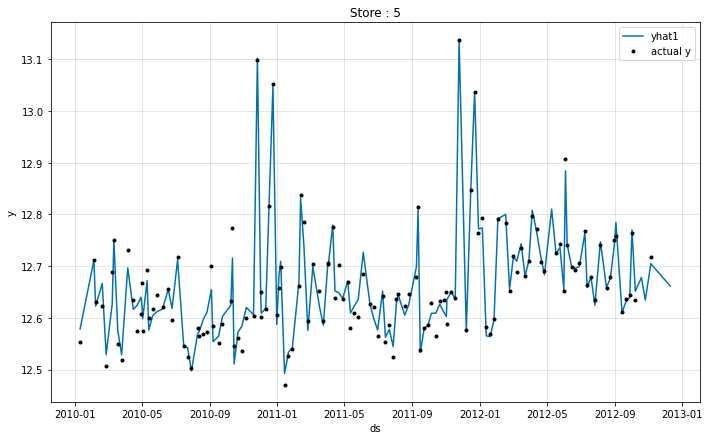

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

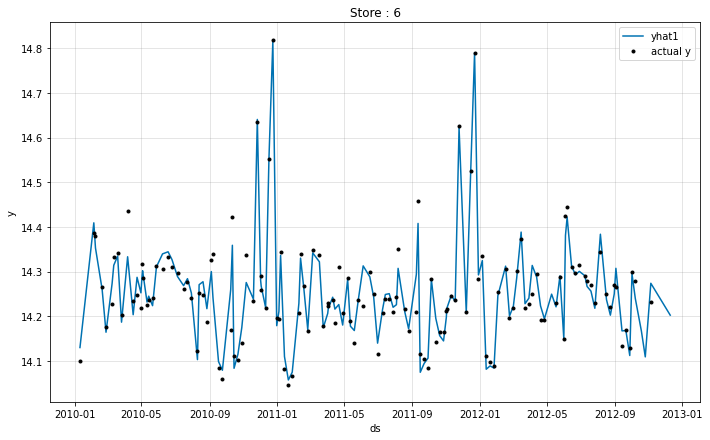

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

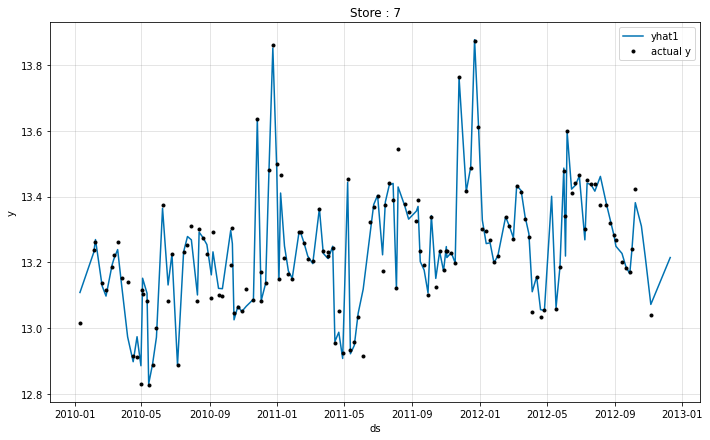

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

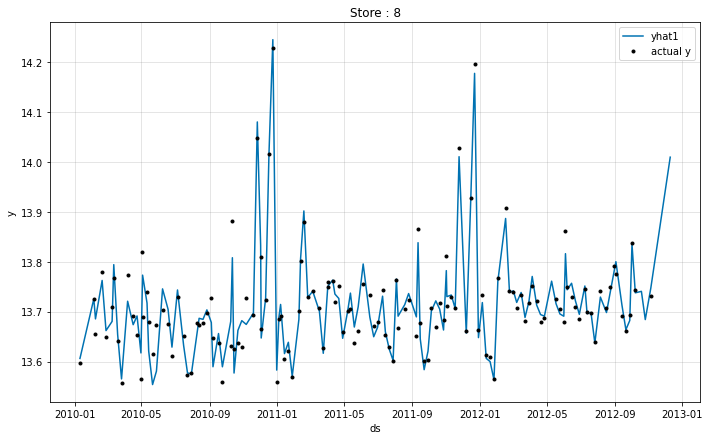

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

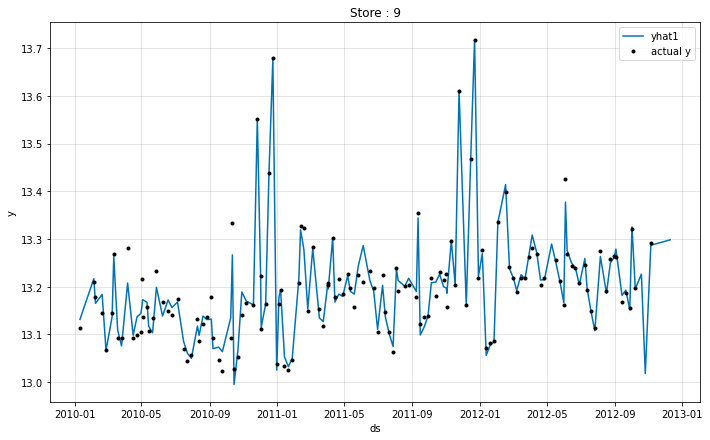

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

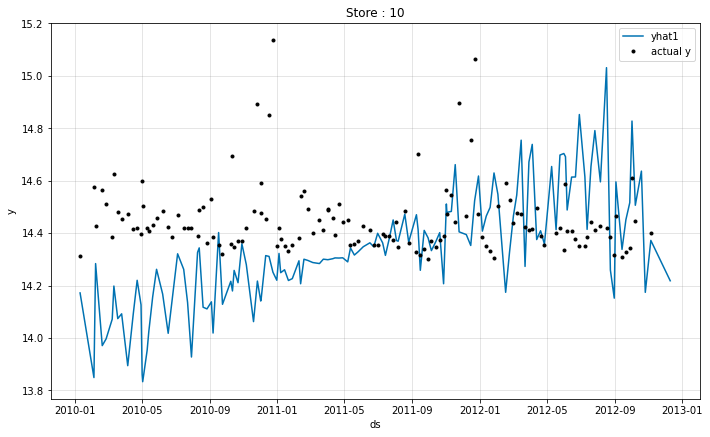

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

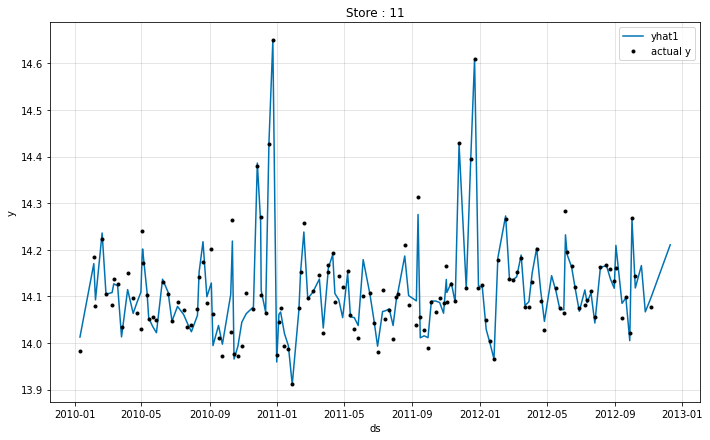

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

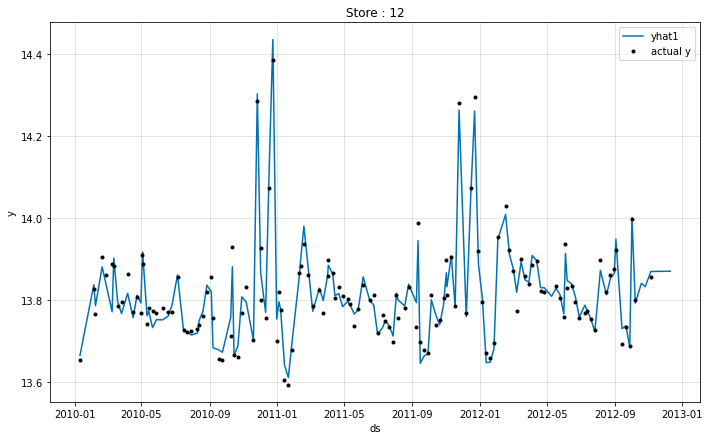

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

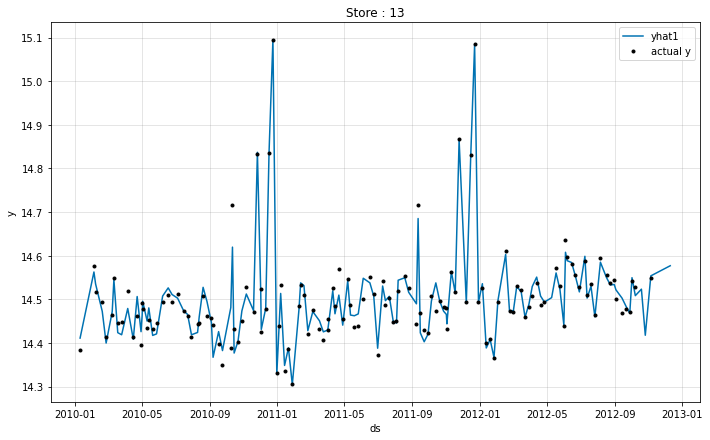

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

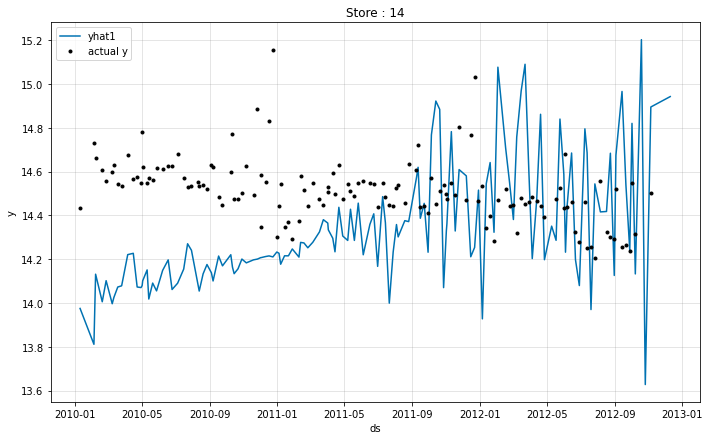

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

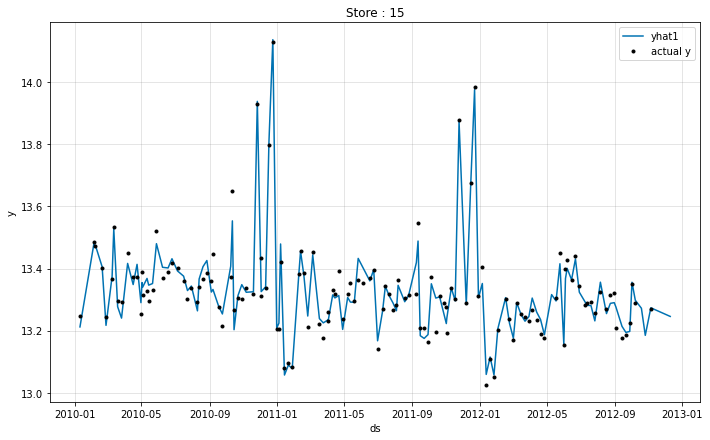

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

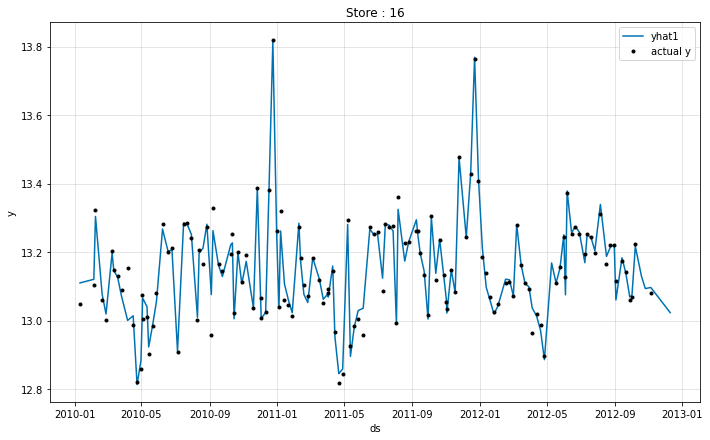

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

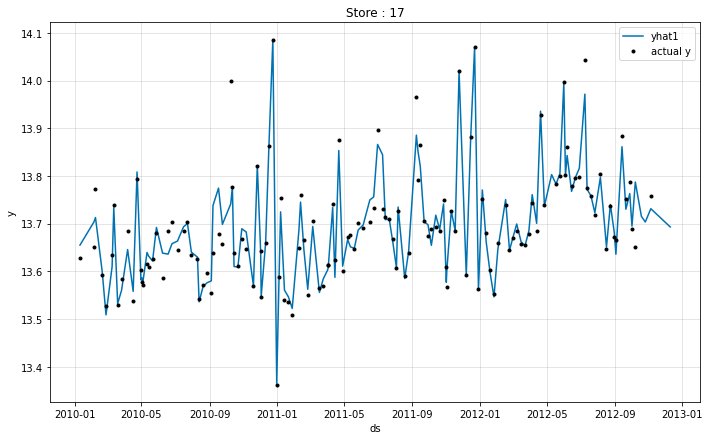

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

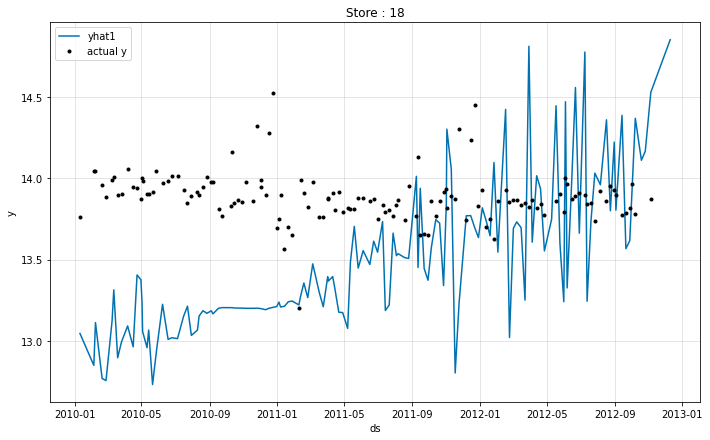

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

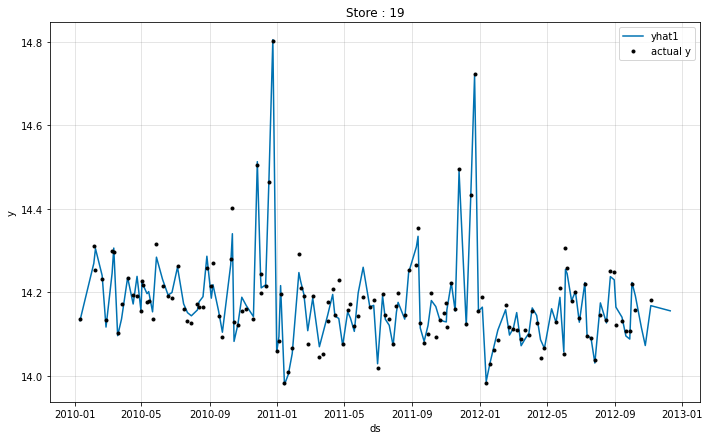

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

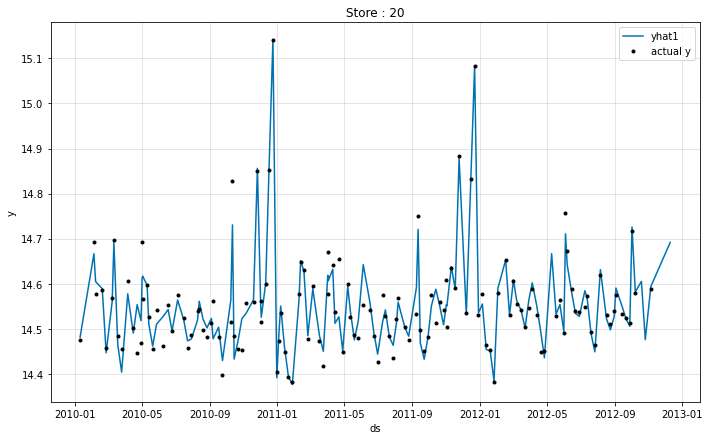

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

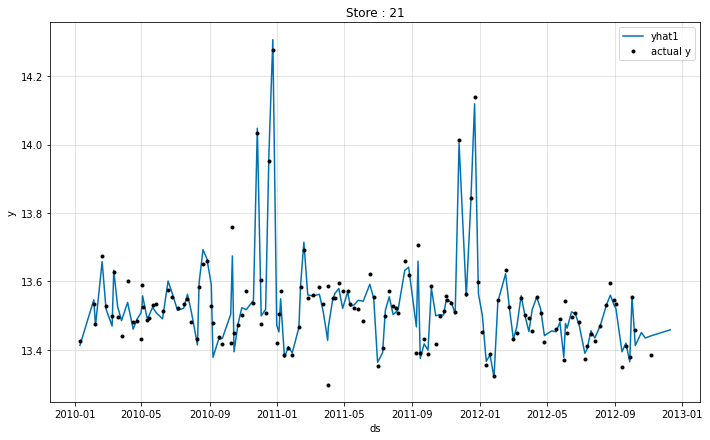

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

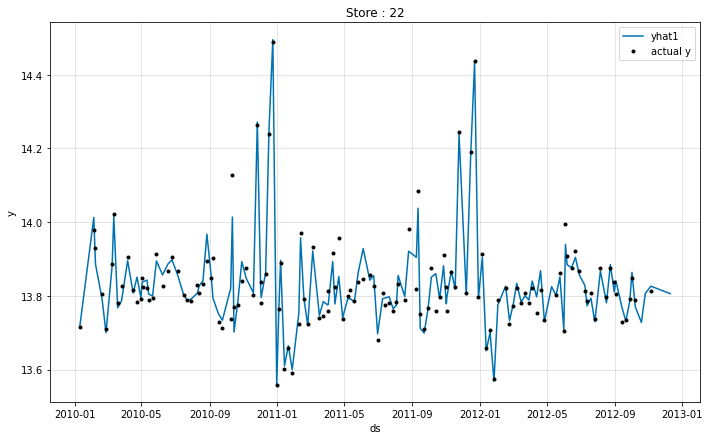

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

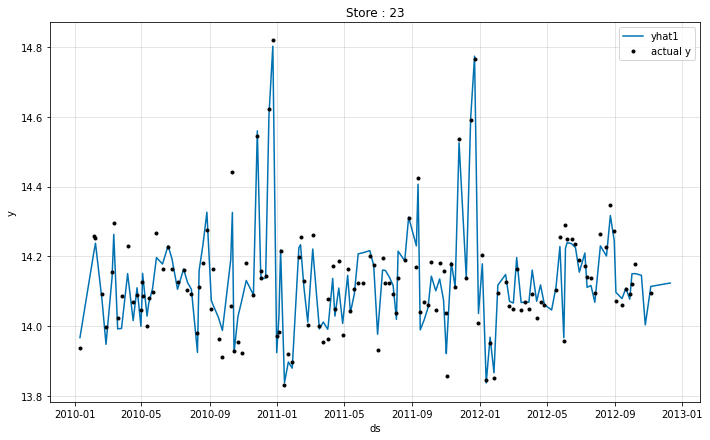

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

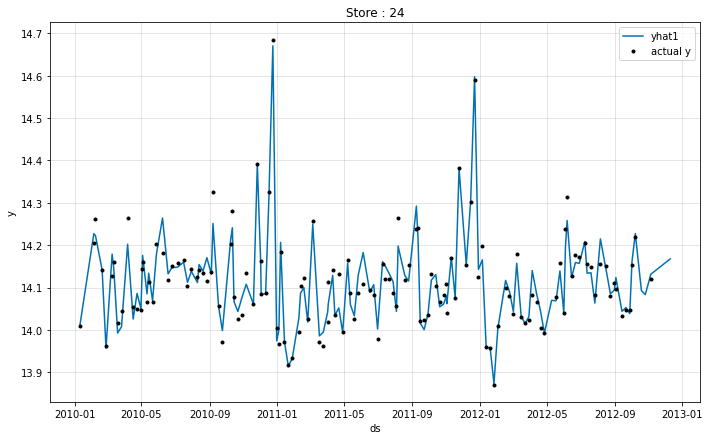

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

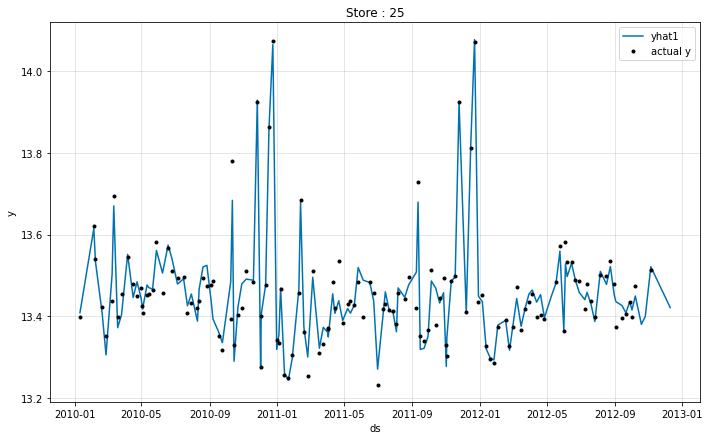

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

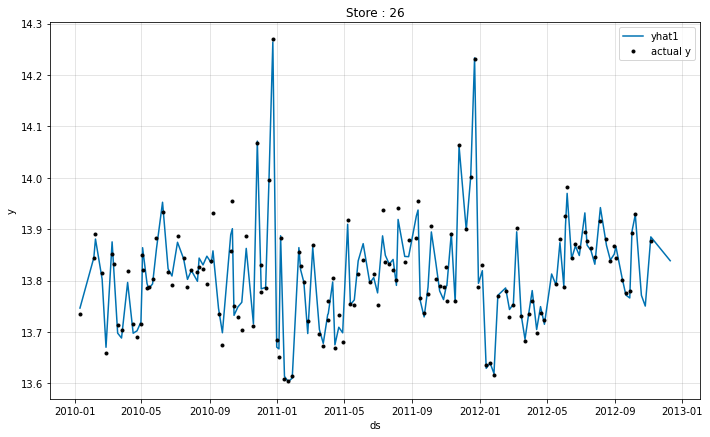

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

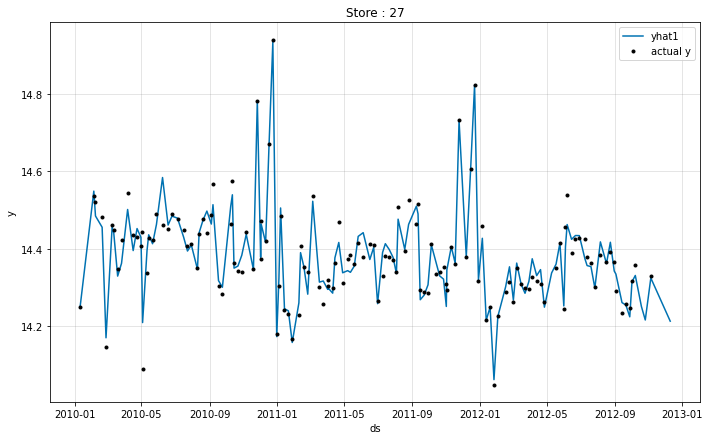

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

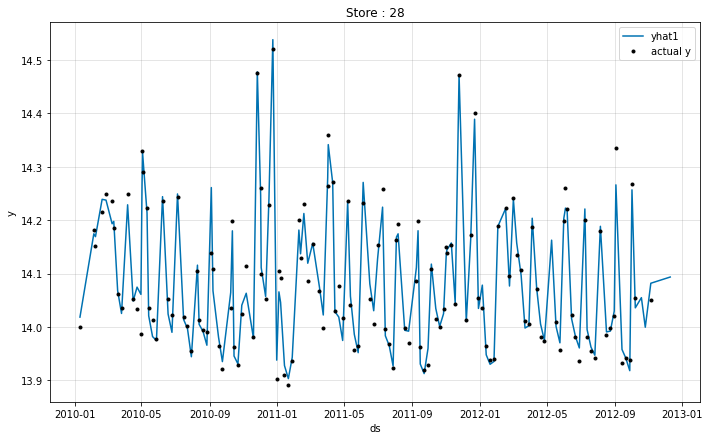

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

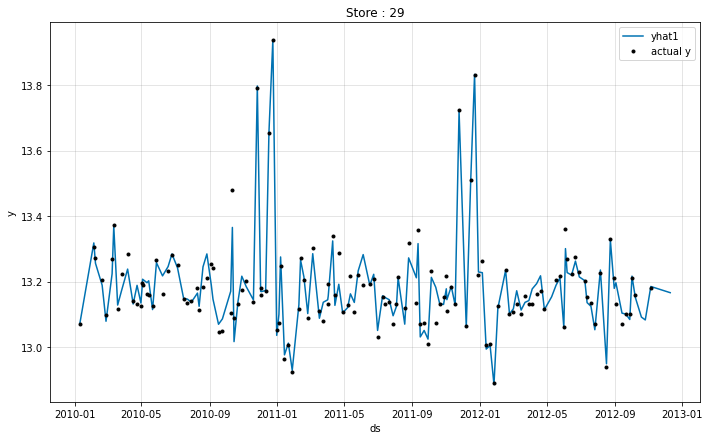

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

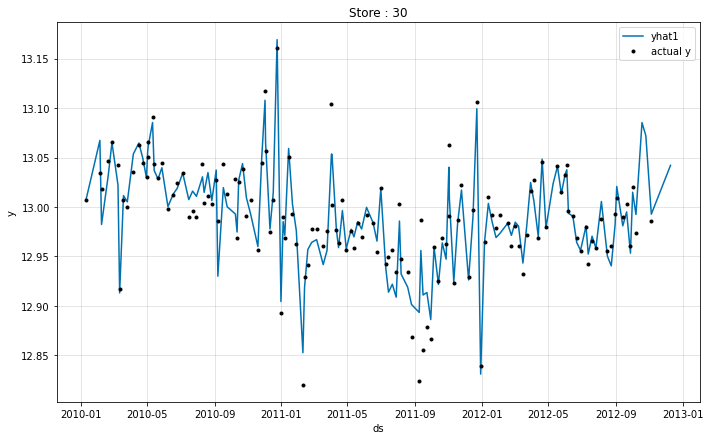

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

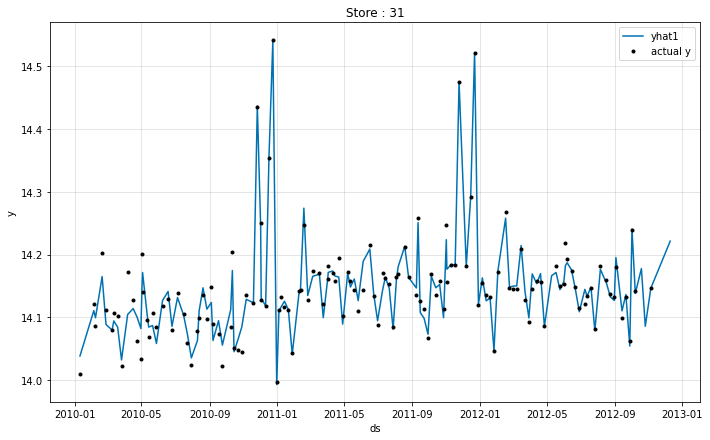

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

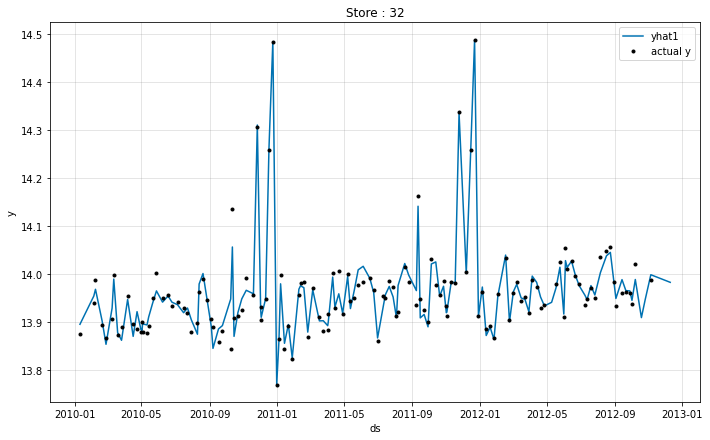

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

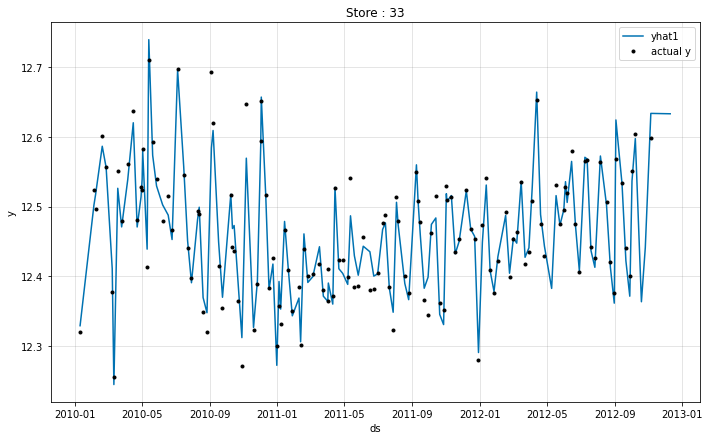

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

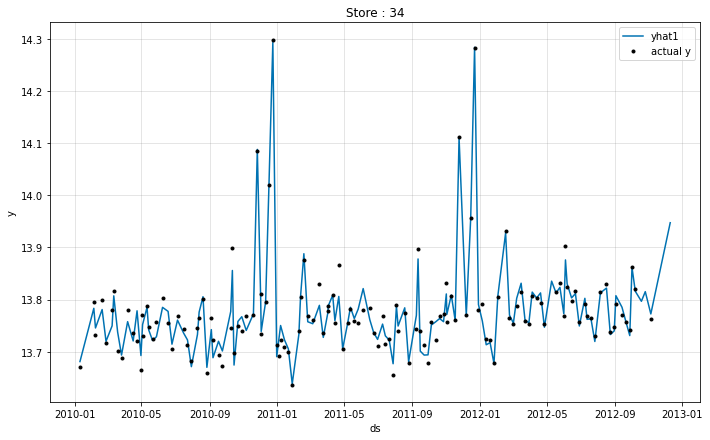

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

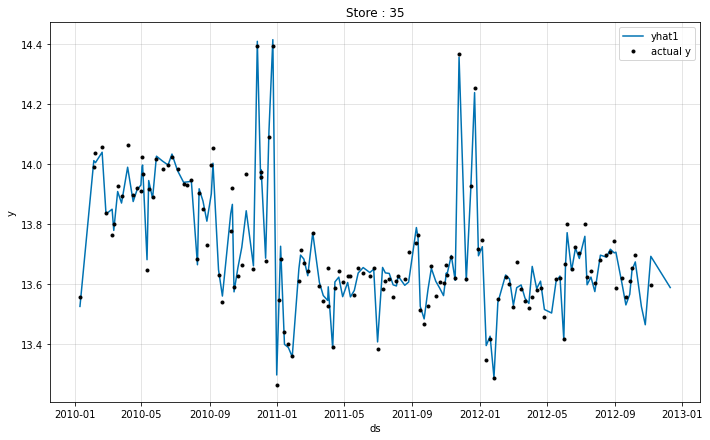

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

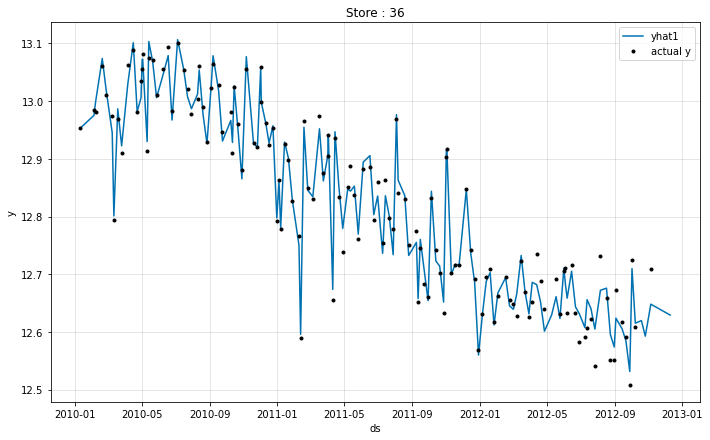

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

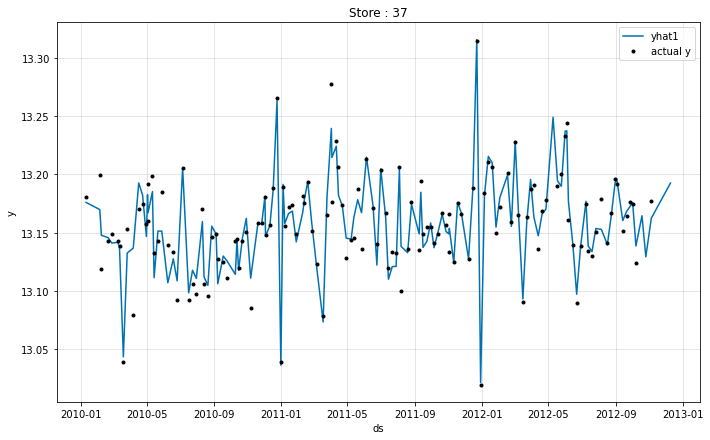

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

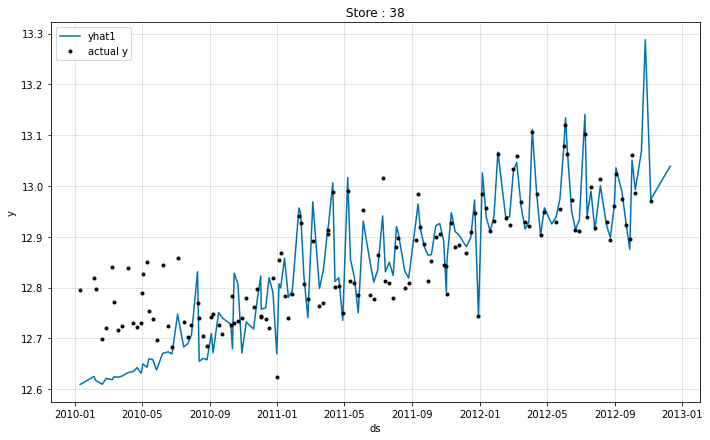

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

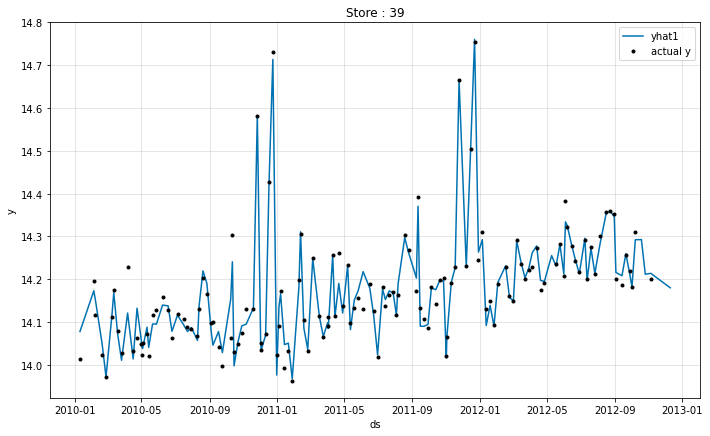

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

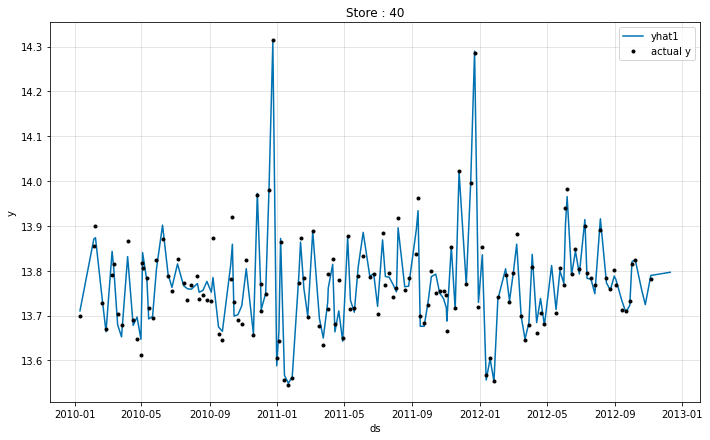

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

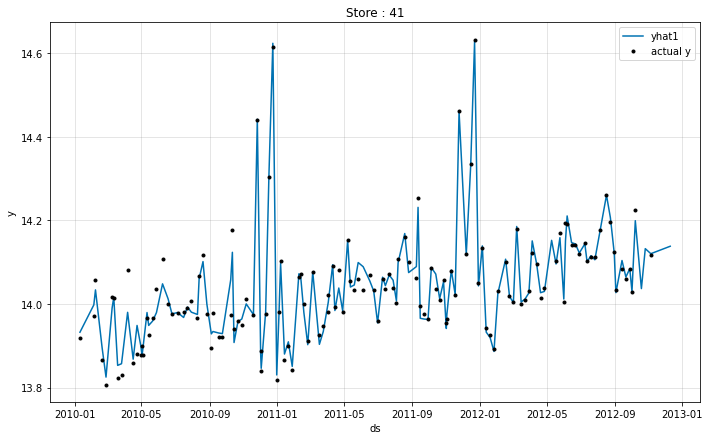

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

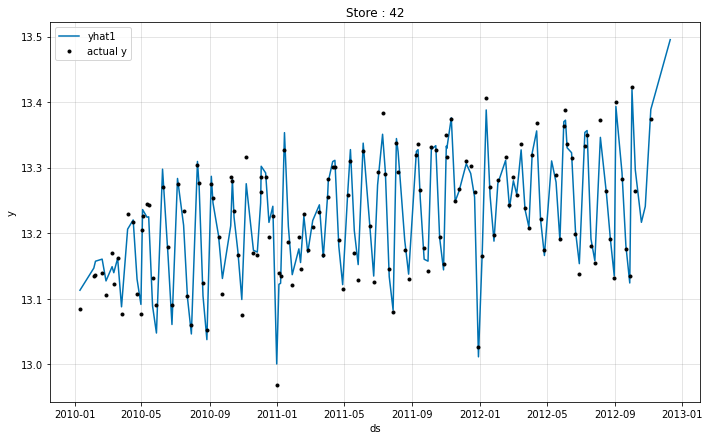

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

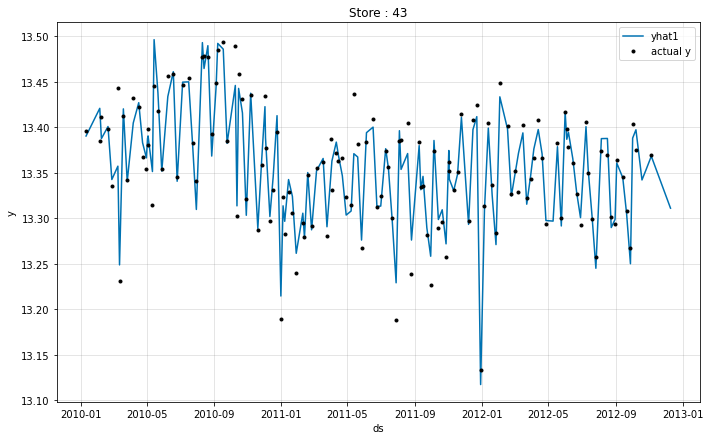

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

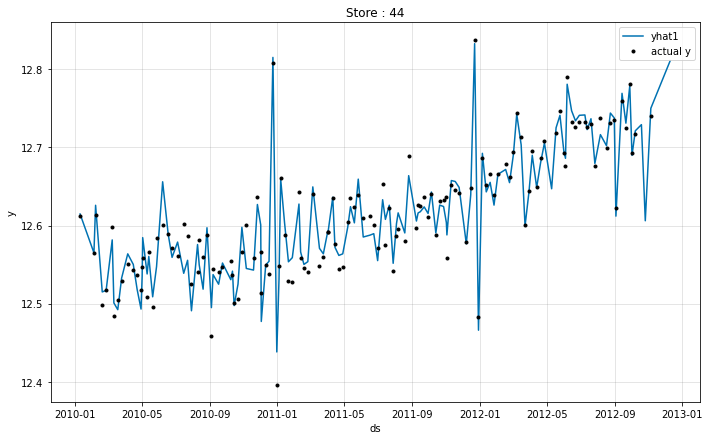

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

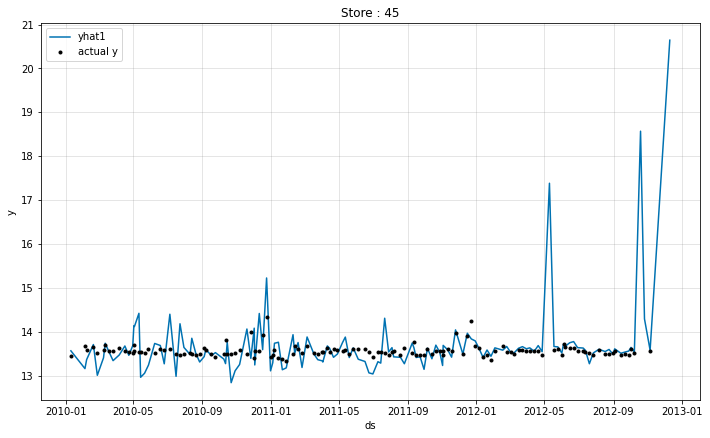

In [14]:
predictions = pd.DataFrame()
for i in train["Store"].unique():
    
    temp = total[total["Store"]==i]
    df = temp[["Date", "Weekly_Sales", "event"]].sort_values("Date")
    df.columns=["ds", "y", "event"]
    
    m = NeuralProphet(
        yearly_seasonality=yearly_seasonality,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode="multiplicative",
        loss_func="MSE",
    )
    
    m = m.add_events(["holiday"])
    history_df = m.create_df_with_events(df[["ds", "y"]],
                                         df[["event", "ds"]][df["event"]=="holiday"])
    
    m.fit(history_df, freq="W")
    forecast = m.predict(history_df)
    
    fig1 = m.plot(forecast)
    plt.title(f"Store : {i}")
    plt.show()
    # fig2 = m.plot_components(forecast)
    # plt.show()
    
    temp["yhat1"] = forecast["yhat1"].values
    predictions = pd.concat([predictions, temp], axis=0)
    
predictions = predictions.sort_index("index")

In [15]:
train = predictions.loc[train.index]
test = predictions.drop(train.index, axis=0)

train.shape, test.shape

((6255, 20), (180, 20))

In [16]:
rmse_best = mean_squared_error(np.exp(train["Weekly_Sales"]).round(2),
                               np.exp(train["yhat1"]).round(2),
                               squared = True)
print("rmse_best: ", rmse_best)
# wandb.log({'RMSE_best': rmse_best})

rmse_best:  28102470261.922836


## Inference

In [17]:
prediction = test['yhat1']

submission = pd.read_csv("data/sample_submission.csv")
submission["Weekly_Sales"] = np.exp(prediction).round(2)
submission.to_csv("submission.csv", index=False)